# TP3 - Market Basket Analysis
INF8111 - Fouille de données, Autonme 2024

In [ ]:
ROOT = ''

## 1. Introduction: Market Basket Analysis

### Présentation

Le *Market Basket Analysis* (MBA) est une technique d'analyse de la fouille de données qui permet de découvrir les associations entre les produits ou leur regroupement. En explorant des motifs intéressants à partir d'une vaste collection de données, le MBA vise à comprendre / révéler les comportements d'achat des clients en se basant sur la théorie selon laquelle si vous avez acheté un certain ensemble de produits, vous êtes plus (ou moins) susceptible d'acheter un autre groupe de produits. En d'autres termes, le MBA permet aux détaillants d'identifier la relation entre les articles que les clients achètent, révélant des tendances d'articles souvent achetés ensemble.

Une approche largement utilisée pour explorer ces motifs consiste à construire *** des règles d'association *** telles que
- **si** acheté *ITEM_1* **alors** achètera *ITEM_2* avec **confiance** *X*.

Ces associations n'ont pas à être des règles individuelles. Ils peuvent impliquer de nombreux éléments. Par exemple, une personne dans un supermarché peut ajouter des œufs dans son panier, puis le MBA peut suggérer qu'elle achètera également du pain et/ou de la farine:

+ **si**  acheté *OEUFS* **alors** achètera [*PAIN* avec confiance *0,2*; *FARINE* avec confiance 0,05].

Cependant, si la personne décide maintenant d'ajouter de la farine à son panier, la nouvelle règle d'association pourrait être comme ci-dessous, suggérant des ingrédients pour faire un gâteau.

+ **si** acheté [*OEUFS, FARINE*] **alors** achètera [*SUCRE* avec confiance 0,45; LEVURE avec confiance 0,12; *PAIN* avec confiance *0,03*].

Il existe de nombreux scénarios réels où le MBA joue un rôle central dans l'analyse des données, comme les transactions de supermarché, les commandes en ligne ou l'historique des cartes de crédit. Avec une approche un peu moins mercantile, cet algorithme est aussi utilisé dans le domaine médical. Les spécialistes du marketing peuvent utiliser ces règles d'association pour organiser les produits corrélés plus près les uns des autres sur les étagères des magasins ou faire des suggestions en ligne afin que les clients achètent plus d'articles. Un MBA peut généralement aider les détaillants à répondre aux questions les suivantes:

- Quels articles sont souvent achetés ensemble ?
- Étant donné un panier, quels articles suggérer ?
- Comment placer les articles ensemble sur les étagères ?


### Objectif

Votre objectif dans ce TP est de développer un algorithme MBA pour révéler les motifs en créant des règles d'association dans un ensemble de données volumineux avec plus de trois millions de transactions de supermarché. Cependant, la collecte de règles d'association dans les grands ensembles de données est un problème très intensif en calcul, ce qui rend presque impossible leur exécution sans système distribué. Par conséquent, pour exécuter votre algorithme, vous aurez accès à un cluster de *cloud computing* distribué avec des centaines de cœurs.

À cette fin, un algorithme **MapReduce** sera implémenté avec le framework [Apache Spark](http://spark.apache.org), un système informatique distribué rapide. En résumé, Spark est un framework open source conçu avec une méthodologie *scale-out* qui en fait un outil très puissant pour les programmeurs ou les développeurs d'applications pour effectuer un volume massif de calculs et de traitement de données dans des environnements distribués. Spark fournit des API de haut niveau qui facilitent la création d'applications parallèles sans avoir à se soucier de la façon dont votre code et vos données sont parallélisés / distribués par le cluster informatique. Spark fait tout pour vous.

La mise en œuvre suivra l'algorithme d'analyse du panier de marché présenté par Jongwook Woo et Yuhang Xu (2012). L'image **workflow.pdf** illustre le flux de travail de l'algorithme et doit être utilisée pour consultation tout au long de ce TP. Les cases bleues sont celles où vous devez implémenter une méthode pour effectuer une fonction de mappage ou de réduction, et les cases grises représentent leur sortie attendue. **Toutes ces opérations sont expliquées en détail dans les sections suivantes.**

## 1. Configuration de Spark

#### Exécution avec le notebook Google Colab (fortement conseillé)

In [ ]:
import os
!apt-get install openjdk-17-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
!pip install pyspark

#### Exécution en local



Spark fonctionne sur les systèmes Windows et UNIX (par exemple, Linux, Mac OS). Il est facile d'exécuter Spark localement sur une seule machine - tout ce dont vous avez besoin est d'avoir Java installé sur votre système PATH, ou la variable d'environnement JAVA_HOME pointant vers une installation Java. Il est obligatoire que le **JDK v8** soit installé sur votre système, car Spark ne prend actuellement en charge que cette version. Si ce n'est pas le cas, accédez à [la page Web de Java](https://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) pour télécharger et installer une machine virtuelle Java. N'oubliez pas de définir la variable d'environnement JAVA_HOME pour utiliser JDK v8 si votre installation ne le fait pas automatiquement.

L'interface entre Python et Spark se fait via **PySpark**, qui peut être installé en exécutant `pip install pyspark` ou configuré en suivant la séquence ci-dessous:

1. D'abord, allez sur http://spark.apache.org/downloads
2. Sélectionnez la dernière version de Spark et le package pré-construit pour Apache Hadoop 2.7
3. Cliquez pour télécharger **spark-2.4.5-bin-hadoop2.7.tgz** et décompressez-le dans le dossier de votre choix.
4. Ensuite, exportez les variables suivantes pour lier PYSPARK (l'interface python de Spark) à votre distribution python dans votre fichier `~/.bash_profile`.

``
export SPARK_HOME=/chemin/ vers / spark-2.4.5-bin-hadoop2.7
export PYTHONPATH="$SPARK_HOME/python:$SPARK_HOME/python/lib/py4j-0.10.7-src.zip:$SPARK_HOME/python/lib/pyspark.zip:$ PYTHONPATH"
export PYSPARK_PYTHON=/chemin/vers/votre/python3
``

5. Exécutez `source ~./bash_profile` pour effectuer les modifications et redémarrer cette session de notebook jupyter.

#### Test de l'installation
À l'aide du code suivant, vous pouvez tester si Spark est correctement installé.

In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.sql("select 'spark' as hello ")
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



### 1.1 Exemple de comptage de produits / Products Counting Example

Pour tester votre installation et commencer à vous familiariser avec Spark, nous suivrons un exemple qui compte combien de fois les produits du GroceryDataset dataset ont été achetés.

Le principal point d'entrée pour commencer la programmation avec Spark est [l'API RDD](https://spark.apache.org/docs/latest/rdd-programming-guide.html), une excellente abstraction Spark pour travailler avec MapReduce. RDD est une collection d'éléments partitionnés sur les nœuds du cluster qui peuvent fonctionner en parallèle. En d'autres termes, RDD est la façon dont Spark maintient vos données prêtes à exécuter une fonction (par exemple, une fonction Map ou une fonction reduce) en parallèle. **Ne vous inquiétez pas si cela semble toujours déroutant, il sera clair une fois que vous commencerez à l'implémenter**. Cependant, cela fait partie de ce TP d'étudier / consulter [Spark python API](https://spark.apache.org/docs/latest/api/python/) et d'apprendre à l'utiliser. Certaines fonctions utiles offertes par l'API RDD sont:

1. **map**: return a new RDD by applying a function to each element of this RDD.
2. **flatMap**: return a new RDD by first applying a function to all elements of this RDD, and then flattening the results. **Should be used when each entry will yield more than one mapped element**
3. **reduce**: reduces the elements of this RDD using the specified commutative and associative binary operator.
4. **reduceByKey**: merge the values for each key using an associative and commutative reduce function
5. **groupByKey**: group the values for each key in the RDD into a single sequence
6. **collect**: return a list that contains all of the elements in this RDD. **Should not be used when working with a lot of data**
7. **takeSample**: return a sampled subset of this RDD
8. **count**: return the number of elements in this RDD.
9. **filter**: return a new RDD containing only the elements that satisfy a predicate.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id

def map_to_product(row):
    """
    Map each transaction into a set of KEY-VALUE elements.
    The KEY is the word (product) itself and the VALUE is its number of apparitions.
    """
    products = row.transaction.split(',') # split products from the column transaction
    for p in products:
        yield (p, 1)

def reduce_product_by_key(value1, value2):
    "Reduce the mapped objects to unique words by merging (summing ) their values"
    return value1+value2

# Initializates a object of SparkSession class, main entry point to Spark's funcionalites
spark = SparkSession.builder.getOrCreate()

# Read a grocery dataset
grocery = spark.read.csv(ROOT + "GroceryDataset.csv") \
              .withColumnRenamed('_c0', 'transaction') \
              .select("*").withColumn("order_id", monotonically_increasing_id())

grocery = grocery.select("order_id", "transaction")

print("Grocery dataset")
grocery.show()

# Obtain a RDD object to call a map function
grocery_rdd = grocery.rdd
print("Grocery dataframe as a RDD object (list of Row objects):\n\t", grocery_rdd.collect())

# Map function to identify all products
grocery_rdd = grocery_rdd.flatMap(map_to_product)
print("\nMapped products:\n\t", grocery_rdd.collect())

# Reduce function to merge values of elements that share the same KEY
grocery_rdd = grocery_rdd.reduceByKey(reduce_product_by_key)
print("\nReduced (merged) products:\n\t", grocery_rdd.collect())

print("\nVisualizing as a dataframe:")
grocery_rdd.toDF(["product", "count_product"]).show()

Grocery dataset
+--------+--------------------+
|order_id|         transaction|
+--------+--------------------+
|       0|  MILK,BREAD,BISCUIT|
|       1|BREAD,MILK,BISCUI...|
|       2| BREAD,TEA,BOURNVITA|
|       3|JAM,MAGGI,BREAD,MILK|
|       4|   MAGGI,TEA,BISCUIT|
|       5| BREAD,TEA,BOURNVITA|
|       6|MAGGI,TEA,CORNFLAKES|
|       7|MAGGI,BREAD,TEA,B...|
|       8| JAM,MAGGI,BREAD,TEA|
|       9|          BREAD,MILK|
|      10|COFFEE,COCK,BISCU...|
|      11|COFFEE,COCK,BISCU...|
|      12|COFFEE,SUGER,BOUR...|
|      13|   BREAD,COFFEE,COCK|
|      14| BREAD,SUGER,BISCUIT|
|      15|COFFEE,SUGER,CORN...|
|      16|BREAD,SUGER,BOURN...|
|      17|  BREAD,COFFEE,SUGER|
|      18|  BREAD,COFFEE,SUGER|
|      19|TEA,MILK,COFFEE,C...|
+--------+--------------------+

Grocery dataframe as a RDD object (list of Row objects):
	 [Row(order_id=0, transaction='MILK,BREAD,BISCUIT'), Row(order_id=1, transaction='BREAD,MILK,BISCUIT,CORNFLAKES'), Row(order_id=2, transaction='BREAD,TEA,BOU

### 1.2 Travailler avec Spark Dataframe / Working with Spark Dataframes

Dans l'exemple ci-dessus, nous avons brièvement utilisé une classe Dataframe de Spark, mais uniquement pour obtenir un objet RDD avec ``toy.rdd`` et pour aficher les données sous forme de tableau structuré avec le ``show ()`` une fonction. Cependant, [Dataframe](http://spark.apache.org/docs/latest/api/python/) est une partie cruciale de la version actuelle de Spark et est construit sur l'API RDD. Il s'agit d'une collection distribuée de lignes sous des colonnes nommées, identique à une table dans une base de données relationnelle. Le Dataframe de Spark fonctionne de la même manière que [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). En fait, nous pouvons exporter (obtenir) une Dataframe Spark vers (à partir de) ​​une Dataframe pandas avec la fonction ``toPandas()``  (``spark.createDataFrame``).

Une fonctionnalité centrale du Dataframe est de bénéficier du [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), un module qui permet des requêtes SQL sur des données structurées. Par exemple, le même « exemple de comptage de produits » aurait pu être implémenté comme une séquence d'opérations SQL sur les données:

In [ ]:
import pyspark.sql.functions as f

# Creates a new column, products, with all products appering in each transaction
print('New column \'products\': exploding the transaction\'s products to a new row')
df_grocery = grocery.withColumn('products', f.explode(f.split(grocery.transaction, ',')))
df_grocery.show()

# Performs a select query and group rows by the product name, aggreagating by counting
print('Couting unique products:')
df_grocery.select(df_grocery.products)\
      .groupBy(df_grocery.products)\
      .agg(f.count('products').alias('count_product'))\
      .sort('count_product', ascending=False)\
      .show()

New column 'products': exploding the transaction's products to a new row
+--------+--------------------+----------+
|order_id|         transaction|  products|
+--------+--------------------+----------+
|       0|  MILK,BREAD,BISCUIT|      MILK|
|       0|  MILK,BREAD,BISCUIT|     BREAD|
|       0|  MILK,BREAD,BISCUIT|   BISCUIT|
|       1|BREAD,MILK,BISCUI...|     BREAD|
|       1|BREAD,MILK,BISCUI...|      MILK|
|       1|BREAD,MILK,BISCUI...|   BISCUIT|
|       1|BREAD,MILK,BISCUI...|CORNFLAKES|
|       2| BREAD,TEA,BOURNVITA|     BREAD|
|       2| BREAD,TEA,BOURNVITA|       TEA|
|       2| BREAD,TEA,BOURNVITA| BOURNVITA|
|       3|JAM,MAGGI,BREAD,MILK|       JAM|
|       3|JAM,MAGGI,BREAD,MILK|     MAGGI|
|       3|JAM,MAGGI,BREAD,MILK|     BREAD|
|       3|JAM,MAGGI,BREAD,MILK|      MILK|
|       4|   MAGGI,TEA,BISCUIT|     MAGGI|
|       4|   MAGGI,TEA,BISCUIT|       TEA|
|       4|   MAGGI,TEA,BISCUIT|   BISCUIT|
|       5| BREAD,TEA,BOURNVITA|     BREAD|
|       5| BREAD,TEA,BOU

En outre, les mêmes opérations SQL effectuées ci-dessus auraient pu être effectuées avec une requête en langage SQL traditionnel comme indiqué ci-dessous:

In [ ]:
# Creates a relational table Grocery in the Spark session
df_grocery.createOrReplaceTempView("Grocery")

spark.sql("SELECT t.products, COUNT(t.products) AS product_count"
          " FROM Grocery t"
          " GROUP BY t.products"
          " ORDER BY product_count DESC").show()

+----------+-------------+
|  products|product_count|
+----------+-------------+
|     BREAD|           13|
|    COFFEE|            8|
|       TEA|            7|
|   BISCUIT|            7|
|CORNFLAKES|            6|
|     SUGER|            6|
|      MILK|            5|
|     MAGGI|            5|
| BOURNVITA|            4|
|      COCK|            3|
|       JAM|            2|
+----------+-------------+



Ces concepts SQL sont mentionnés ici car ils nous seront utiles lors du TP, principalement dans la section 3, pour manipuler les données du supermarché, qui sont structurées en tableaux. Ainsi, si vous n'êtes pas familier avec SQL, il est recommandé de suivre un [tutoriel](https://www.w3schools.com/sql/) pour comprendre les bases.



## 2. Algorithme MBA (45 points)
Les sections suivantes expliquent comment développer chaque étape de l'algorithme MapReduce pour notre application commerciale. La figure workflow.pdf illustre chaque étape de l'algorithme.



### 2.1 Map to Patterns (10 points)
Pour un sous-ensemble de transactions (c'est-à-dire les lignes de notre grocery dataset), chaque transaction doit être **mappée** vers un ensemble de *motifs d'achat* trouvés dans la transaction. Formellement, ces motifs sont des sous-ensembles de produits qui représentent un groupe d'articles achetés ensemble.

Pour le framework MapReduce, chaque motif doit être créé comme un élément *KEY-VALUE*, où la KEY peut prendre la forme d'un singleton, d'une paire ou d'un trio de produits présents dans la transaction. Plus précisément, pour chaque transaction, la fonction de mappage doit générer tous les sous-ensembles **UNIQUE** possibles de taille **UN, DEUX ou TROIS**. La VALEUR associée à chaque KEY est le nombre de fois que la KEY est apparue dans la transaction (si nous supposons qu'aucun produit n'apparaît plus d'une fois dans la transaction, cette valeur est toujours égale à un).

Maintenant, implémentez la fonction **map_to_patterns** qui reçoit une transaction (une ligne du dataset) et retourne les motifs trouvés dans la transaction. Les éléments mappés sont un tuple (KEY, VALUE), où KEY est également un tuple de noms de produits. Il est crucial de noter que, puisque chaque entrée (transaction) de la fonction MAP produira **plus** un élément KEY-VALUE, un *flatMap* doit être invoqué pour cette étape. Pour le "grocery dataset", la sortie attendue est :

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 20em; padding-left:1px">
<code>
+-----------------------------------+-----------+
|patterns                           |occurrences|
+-----------------------------------+-----------+
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |1          |
|('BISCUIT', 'BREAD', 'MAGGI')      |1          |
|('BISCUIT', 'BREAD', 'MILK')       |1          |
|('BISCUIT', 'BREAD', 'MILK')       |1          |
|('BISCUIT', 'BREAD', 'SUGER')      |1          |
|('BISCUIT', 'BREAD', 'TEA')        |1          |
|('BISCUIT', 'COCK')                |1          |
|('BISCUIT', 'COCK')                |1          |
|('BISCUIT', 'COCK', 'COFFEE')      |1          |
|('BISCUIT', 'COCK', 'COFFEE')      |1          |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |1          |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |1          |
|('BISCUIT', 'COFFEE')              |1          |
|('BISCUIT', 'COFFEE')              |1          |
|('BISCUIT', 'COFFEE', 'CORNFLAKES')|1          |
|('BISCUIT', 'COFFEE', 'CORNFLAKES')|1          |
|('BISCUIT', 'CORNFLAKES')          |1          |
|('BISCUIT', 'CORNFLAKES')          |1          |
|('BISCUIT', 'CORNFLAKES')          |1          |
|('BISCUIT', 'CORNFLAKES', 'MILK')  |1          |
|('BISCUIT', 'MAGGI')               |1          |
|('BISCUIT', 'MAGGI')               |1          |
|('BISCUIT', 'MAGGI', 'TEA')        |1          |
|('BISCUIT', 'MAGGI', 'TEA')        |1          |
|('BISCUIT', 'MILK')                |1          |
|('BISCUIT', 'MILK')                |1          |
|('BISCUIT', 'SUGER')               |1          |
|('BISCUIT', 'TEA')                 |1          |
|('BISCUIT', 'TEA')                 |1          |
|('BISCUIT',)                       |1          |
|('BISCUIT',)                       |1          |
|('BISCUIT',)                       |1          |
|('BISCUIT',)                       |1          |
|('BISCUIT',)                       |1          |
|('BISCUIT',)                       |1          |
|('BISCUIT',)                       |1          |
|('BOURNVITA', 'BREAD')             |1          |
|('BOURNVITA', 'BREAD')             |1          |
|('BOURNVITA', 'BREAD')             |1          |
|('BOURNVITA', 'BREAD', 'SUGER')    |1          |
|('BOURNVITA', 'BREAD', 'TEA')      |1          |
|('BOURNVITA', 'BREAD', 'TEA')      |1          |
|('BOURNVITA', 'COFFEE')            |1          |
|('BOURNVITA', 'COFFEE', 'SUGER')   |1          |
|('BOURNVITA', 'SUGER')             |1          |
|('BOURNVITA', 'SUGER')             |1          |
+-----------------------------------+-----------+
</code>
</pre>

Votre sortie devra ainsi être **exactement** la même, sans quoi aucun point ne pourra vous être attribué pour cette question.

In [ ]:
from itertools import combinations

def format_tuples(pattern):
    """
    Used for visualizition.
    Transforms tuples to a string since Dataframe does not support column of tuples with different sizes
    (a,b,c) -> '(a,b,c)'
    """
    return (str(pattern[0]), str(pattern[1]))

def map_to_patterns(row):
    products = sorted(row.transaction.split(","))

    for size in range(1, 4):
        for comb in combinations(products, size):
            yield (tuple(comb), 1) #renvoyer tout en tant que tuple


grocery_rdd = grocery.rdd
patterns_rdd = grocery_rdd.flatMap(map_to_patterns)
# # Output as dataframe
patterns_rdd.map(format_tuples).toDF(['patterns', 'occurrences']).sort(['patterns']).show(50, truncate=False)

+-----------------------------------+-----------+
|patterns                           |occurrences|
+-----------------------------------+-----------+
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |1          |
|('BISCUIT', 'BREAD', 'MAGGI')      |1          |
|('BISCUIT', 'BREAD', 'MILK')       |1          |
|('BISCUIT', 'BREAD', 'MILK')       |1          |
|('BISCUIT', 'BREAD', 'SUGER')      |1          |
|('BISCUIT', 'BREAD', 'TEA')        |1          |
|('BISCUIT', 'COCK')                |1          |
|('BISCUIT', 'COCK')                |1          |
|('BISCUIT', 'COCK', 'COFFEE')      |1          |
|('BISCUIT', 'COCK', 'COFFEE')      |1          |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |1          |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |1          |
|('BISCUIT', 'COFFEE')              |1          |


### 2.2  Reduce patterns  (2,5 points)
Une fois que différents processeurs ont traité les transactions, une fonction **reduce** doit être appelée pour combiner des KEYS identiques (le sous-ensemble de produits) et calculer le nombre total de ses occurrences dans le dataset. En d'autres termes, cette procédure de réduction doit additionner la *VALUE* de chaque KEY identique.

Créez ci-dessous une fonction **reduce_patterns** qui doit additionner la VALUE de chaque motif.
Pour le "grocery dataset", la sortie attendue est:

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 28em; padding-left:5px">
<code>
+-----------------------------------+--------------------+
|patterns                           |combined_occurrences|
+-----------------------------------+--------------------+
|('BISCUIT', 'BREAD')               |4                   |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |1                   |
|('BISCUIT', 'BREAD', 'MAGGI')      |1                   |
|('BISCUIT', 'BREAD', 'MILK')       |2                   |
|('BISCUIT', 'BREAD', 'SUGER')      |1                   |
|('BISCUIT', 'BREAD', 'TEA')        |1                   |
|('BISCUIT', 'COCK')                |2                   |
|('BISCUIT', 'COCK', 'COFFEE')      |2                   |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |2                   |
|('BISCUIT', 'COFFEE')              |2                   |
|('BISCUIT', 'COFFEE', 'CORNFLAKES')|2                   |
|('BISCUIT', 'CORNFLAKES')          |3                   |
|('BISCUIT', 'CORNFLAKES', 'MILK')  |1                   |
|('BISCUIT', 'MAGGI')               |2                   |
|('BISCUIT', 'MAGGI', 'TEA')        |2                   |
|('BISCUIT', 'MILK')                |2                   |
|('BISCUIT', 'SUGER')               |1                   |
|('BISCUIT', 'TEA')                 |2                   |
|('BISCUIT',)                       |7                   |
|('BOURNVITA', 'BREAD')             |3                   |
|('BOURNVITA', 'BREAD', 'SUGER')    |1                   |
|('BOURNVITA', 'BREAD', 'TEA')      |2                   |
|('BOURNVITA', 'COFFEE')            |1                   |
|('BOURNVITA', 'COFFEE', 'SUGER')   |1                   |
|('BOURNVITA', 'SUGER')             |2                   |
|('BOURNVITA', 'TEA')               |2                   |
|('BOURNVITA',)                     |4                   |
|('BREAD', 'COCK')                  |1                   |
|('BREAD', 'COCK', 'COFFEE')        |1                   |
|('BREAD', 'COFFEE')                |3                   |
|('BREAD', 'COFFEE', 'SUGER')       |2                   |
|('BREAD', 'CORNFLAKES')            |1                   |
|('BREAD', 'CORNFLAKES', 'MILK')    |1                   |
|('BREAD', 'JAM')                   |2                   |
|('BREAD', 'JAM', 'MAGGI')          |2                   |
|('BREAD', 'JAM', 'MILK')           |1                   |
|('BREAD', 'JAM', 'TEA')            |1                   |
|('BREAD', 'MAGGI')                 |3                   |
|('BREAD', 'MAGGI', 'MILK')         |1                   |
|('BREAD', 'MAGGI', 'TEA')          |2                   |
|('BREAD', 'MILK')                  |4                   |
|('BREAD', 'SUGER')                 |4                   |
|('BREAD', 'TEA')                   |4                   |
|('BREAD',)                         |13                  |
|('COCK', 'COFFEE')                 |3                   |
|('COCK', 'COFFEE', 'CORNFLAKES')   |2                   |
|('COCK', 'CORNFLAKES')             |2                   |
|('COCK',)                          |3                   |
|('COFFEE', 'CORNFLAKES')           |4                   |
|('COFFEE', 'CORNFLAKES', 'MILK')   |1                   |
+-----------------------------------+--------------------+
</code>
</pre>

Votre sortie devra ainsi être **exactement** la même, sans quoi aucun point ne pourra vous être attribué pour cette question.


In [ ]:
def reduce_patterns(v1, v2):
    """
    TODO
    """
    return v1+v2

combined_patterns_rdd = patterns_rdd.reduceByKey(reduce_patterns)

# Output as dataframe
combined_patterns_rdd.map(format_tuples).toDF(['patterns', 'combined_occurrences']).sort(['patterns']).show(50, truncate=False)

+-----------------------------------+--------------------+
|patterns                           |combined_occurrences|
+-----------------------------------+--------------------+
|('BISCUIT', 'BREAD')               |4                   |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |1                   |
|('BISCUIT', 'BREAD', 'MAGGI')      |1                   |
|('BISCUIT', 'BREAD', 'MILK')       |2                   |
|('BISCUIT', 'BREAD', 'SUGER')      |1                   |
|('BISCUIT', 'BREAD', 'TEA')        |1                   |
|('BISCUIT', 'COCK')                |2                   |
|('BISCUIT', 'COCK', 'COFFEE')      |2                   |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |2                   |
|('BISCUIT', 'COFFEE')              |2                   |
|('BISCUIT', 'COFFEE', 'CORNFLAKES')|2                   |
|('BISCUIT', 'CORNFLAKES')          |3                   |
|('BISCUIT', 'CORNFLAKES', 'MILK')  |1                   |
|('BISCUIT', 'MAGGI')               |2                  

### 2.3 Map to subpatterns (15 points)
Ensuite, une autre fonction **map** doit être appliquée pour générer des sous-motifs. Encore une fois, les sous-motifs sont des éléments KEY-VALUE, où la KEY est également un sous-ensemble de produits. Cependant, la création de la KEY du sous-motif est une procédure différente. Cette fois, l'idée est de décomposer la liste des produits de chaque motif (KEY), de supprimer un produit à la fois et de produire la liste résultante en tant que nouvelle clé de sous-motif.

Par exemple, pour un modèle donné $P$ avec trois produits, $p_1, p_2$ et $p_3$, trois nouvelles clés de sous-motifs vont être créées: (i) supprimer $p_1$ et retourner ($p_2, p_3$) ; (ii) supprimer $p_2$ et retourner ($p_1, p_3$); et (iii) supprimer $p_3$ et retourner ($p_1, p_2$).

De plus, la structure VALUE du sous-motif sera également différente. Au lieu d'une seule valeur entière unique comme nous l'avons eu dans les motifs, cette fois un *tuple* devrait être créé pour le sous-motif VALUE. Ce tuple contient le produit qui a été retiré lors de la remise de la KEY et le nombre de fois que le motif est apparu. Par exemple ci-dessus, les valeurs doivent être ($p_1,v$), ($p_2,v$) et ($p_3,v $), respectivement, où $v$ est la VALEUR du motif.

L'idée derrière les sous-motif est de créer **des règles** telles que : lorsque les produits de KEY ont été achetés, l'article présent dans la VALEUR a également été acheté *v* fois. En outre, chaque motif doit également produire un sous-motif dans lequel la clé est la même liste de produits du motif, mais la valeur est un tuple avec un produit nul (None) et le nombre de fois que le motif est apparu. Cet élément sera utile pour garder une trace du nombre de fois où un tel motif a été trouvé et sera utilisé ultérieurement pour calculer la valeur de confiance lors de la génération des règles d'association.

Maintenant, implémentez la fonction **map_to_subpatterns** qui reçoit un motif et produit tous les sous-motif trouvés. Encore une fois, chaque entrée (motif) générera plus d'un élément KEY-VALUE, puis une fonction flatMap doit être appelée.

Pour le "grocery dataset", la sortie attendue est:

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 20em; padding-left:5px">
<code>
+-----------------------------------+-----------------+
|subpatterns                        |rules            |
+-----------------------------------+-----------------+
|('BISCUIT', 'BREAD')               |(None, 4)        |
|('BISCUIT', 'BREAD')               |('MILK', 2)      |
|('BISCUIT', 'BREAD')               |('CORNFLAKES', 1)|
|('BISCUIT', 'BREAD')               |('MAGGI', 1)     |
|('BISCUIT', 'BREAD')               |('TEA', 1)       |
|('BISCUIT', 'BREAD')               |('SUGER', 1)     |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |(None, 1)        |
|('BISCUIT', 'BREAD', 'MAGGI')      |(None, 1)        |
|('BISCUIT', 'BREAD', 'MILK')       |(None, 2)        |
|('BISCUIT', 'BREAD', 'SUGER')      |(None, 1)        |
|('BISCUIT', 'BREAD', 'TEA')        |(None, 1)        |
|('BISCUIT', 'COCK')                |(None, 2)        |
|('BISCUIT', 'COCK')                |('COFFEE', 2)    |
|('BISCUIT', 'COCK')                |('CORNFLAKES', 2)|
|('BISCUIT', 'COCK', 'COFFEE')      |(None, 2)        |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |(None, 2)        |
|('BISCUIT', 'COFFEE')              |(None, 2)        |
|('BISCUIT', 'COFFEE')              |('COCK', 2)      |
|('BISCUIT', 'COFFEE')              |('CORNFLAKES', 2)|
|('BISCUIT', 'COFFEE', 'CORNFLAKES')|(None, 2)        |
|('BISCUIT', 'CORNFLAKES')          |(None, 3)        |
|('BISCUIT', 'CORNFLAKES')          |('BREAD', 1)     |
|('BISCUIT', 'CORNFLAKES')          |('MILK', 1)      |
|('BISCUIT', 'CORNFLAKES')          |('COCK', 2)      |
|('BISCUIT', 'CORNFLAKES')          |('COFFEE', 2)    |
|('BISCUIT', 'CORNFLAKES', 'MILK')  |(None, 1)        |
|('BISCUIT', 'MAGGI')               |(None, 2)        |
|('BISCUIT', 'MAGGI')               |('TEA', 2)       |
|('BISCUIT', 'MAGGI')               |('BREAD', 1)     |
|('BISCUIT', 'MAGGI', 'TEA')        |(None, 2)        |
|('BISCUIT', 'MILK')                |(None, 2)        |
|('BISCUIT', 'MILK')                |('BREAD', 2)     |
|('BISCUIT', 'MILK')                |('CORNFLAKES', 1)|
|('BISCUIT', 'SUGER')               |(None, 1)        |
|('BISCUIT', 'SUGER')               |('BREAD', 1)     |
|('BISCUIT', 'TEA')                 |(None, 2)        |
|('BISCUIT', 'TEA')                 |('MAGGI', 2)     |
|('BISCUIT', 'TEA')                 |('BREAD', 1)     |
|('BISCUIT',)                       |(None, 7)        |
|('BISCUIT',)                       |('BREAD', 4)     |
|('BISCUIT',)                       |('MILK', 2)      |
|('BISCUIT',)                       |('CORNFLAKES', 3)|
|('BISCUIT',)                       |('MAGGI', 2)     |
|('BISCUIT',)                       |('TEA', 2)       |
|('BISCUIT',)                       |('COCK', 2)      |
|('BISCUIT',)                       |('COFFEE', 2)    |
|('BISCUIT',)                       |('SUGER', 1)     |
|('BOURNVITA', 'BREAD')             |(None, 3)        |
|('BOURNVITA', 'BREAD')             |('TEA', 2)       |
|('BOURNVITA', 'BREAD')             |('SUGER', 1)     |
+-----------------------------------+-----------------+
</code>
</pre>

Votre sortie devra ainsi être **exactement** la même, sans quoi aucun point ne pourra vous être attribué pour cette question.

In [ ]:
from copy import deepcopy
def map_to_subpatterns(pattern):
    """
    TODO
    """
    subpattern, values = pattern
    n = len(subpattern)

    if n == 1:
        yield (subpattern, (None, values))
    else:
        yield (subpattern, (None, values))
        for i in range(n):
            subpattern_i = subpattern[:i] + subpattern[i+1:]
            yield (tuple(subpattern_i), (subpattern[i], values))

subpatterns_rdd = combined_patterns_rdd.flatMap(map_to_subpatterns)
# Output as dataframe
subpatterns_rdd.map(format_tuples).toDF(['subpatterns', 'rules']).sort(['subpatterns']).show(50, truncate=False)

+-----------------------------------+-----------------+
|subpatterns                        |rules            |
+-----------------------------------+-----------------+
|('BISCUIT', 'BREAD')               |(None, 4)        |
|('BISCUIT', 'BREAD')               |('MILK', 2)      |
|('BISCUIT', 'BREAD')               |('CORNFLAKES', 1)|
|('BISCUIT', 'BREAD')               |('MAGGI', 1)     |
|('BISCUIT', 'BREAD')               |('TEA', 1)       |
|('BISCUIT', 'BREAD')               |('SUGER', 1)     |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |(None, 1)        |
|('BISCUIT', 'BREAD', 'MAGGI')      |(None, 1)        |
|('BISCUIT', 'BREAD', 'MILK')       |(None, 2)        |
|('BISCUIT', 'BREAD', 'SUGER')      |(None, 1)        |
|('BISCUIT', 'BREAD', 'TEA')        |(None, 1)        |
|('BISCUIT', 'COCK')                |(None, 2)        |
|('BISCUIT', 'COCK')                |('COFFEE', 2)    |
|('BISCUIT', 'COCK')                |('CORNFLAKES', 2)|
|('BISCUIT', 'COCK', 'COFFEE')      |(None, 2)  

### 2.4 Reduce Subpatterns (2.5 points)

Encore une fois, une fonction **reduce** est nécessaire pour regrouper tous les sous-motif par leur KEY. L'objectif de cette procédure de réduction est de créer une liste de toutes les **règles** apparues dans KEY. Par conséquent, la sortie attendue résultant de cette fonction de réduction est également un élément KEY-VALUE, où la clé est la KEY du sous-motif et la valeur est un groupe contenant toutes les valeurs des sous-motif qui partagent la même clé.

Pour le "grocery dataset", la sortie attendue est:

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 50em; padding-left:5px">
<code>
+-----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|subpatterns                        |combined_rules                                                                                                                                                |
+-----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|('BISCUIT', 'BREAD')               |[(None, 4), ('MILK', 2), ('CORNFLAKES', 1), ('MAGGI', 1), ('TEA', 1), ('SUGER', 1)]                                                                           |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |[(None, 1)]                                                                                                                                                   |
|('BISCUIT', 'BREAD', 'MAGGI')      |[(None, 1)]                                                                                                                                                   |
|('BISCUIT', 'BREAD', 'MILK')       |[(None, 2)]                                                                                                                                                   |
|('BISCUIT', 'BREAD', 'SUGER')      |[(None, 1)]                                                                                                                                                   |
|('BISCUIT', 'BREAD', 'TEA')        |[(None, 1)]                                                                                                                                                   |
|('BISCUIT', 'COCK')                |[(None, 2), ('COFFEE', 2), ('CORNFLAKES', 2)]                                                                                                                 |
|('BISCUIT', 'COCK', 'COFFEE')      |[(None, 2)]                                                                                                                                                   |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |[(None, 2)]                                                                                                                                                   |
|('BISCUIT', 'COFFEE')              |[(None, 2), ('COCK', 2), ('CORNFLAKES', 2)]                                                                                                                   |
|('BISCUIT', 'COFFEE', 'CORNFLAKES')|[(None, 2)]                                                                                                                                                   |
|('BISCUIT', 'CORNFLAKES')          |[(None, 3), ('BREAD', 1), ('MILK', 1), ('COCK', 2), ('COFFEE', 2)]                                                                                            |
|('BISCUIT', 'CORNFLAKES', 'MILK')  |[(None, 1)]                                                                                                                                                   |
|('BISCUIT', 'MAGGI')               |[(None, 2), ('TEA', 2), ('BREAD', 1)]                                                                                                                         |
|('BISCUIT', 'MAGGI', 'TEA')        |[(None, 2)]                                                                                                                                                   |
|('BISCUIT', 'MILK')                |[(None, 2), ('BREAD', 2), ('CORNFLAKES', 1)]                                                                                                                  |
|('BISCUIT', 'SUGER')               |[(None, 1), ('BREAD', 1)]                                                                                                                                     |
|('BISCUIT', 'TEA')                 |[(None, 2), ('MAGGI', 2), ('BREAD', 1)]                                                                                                                       |
|('BISCUIT',)                       |[(None, 7), ('BREAD', 4), ('MILK', 2), ('CORNFLAKES', 3), ('MAGGI', 2), ('TEA', 2), ('COCK', 2), ('COFFEE', 2), ('SUGER', 1)]                                 |
|('BOURNVITA', 'BREAD')             |[(None, 3), ('TEA', 2), ('SUGER', 1)]                                                                                                                         |
|('BOURNVITA', 'BREAD', 'SUGER')    |[(None, 1)]                                                                                                                                                   |
|('BOURNVITA', 'BREAD', 'TEA')      |[(None, 2)]                                                                                                                                                   |
|('BOURNVITA', 'COFFEE')            |[(None, 1), ('SUGER', 1)]                                                                                                                                     |
|('BOURNVITA', 'COFFEE', 'SUGER')   |[(None, 1)]                                                                                                                                                   |
|('BOURNVITA', 'SUGER')             |[(None, 2), ('COFFEE', 1), ('BREAD', 1)]                                                                                                                      |
|('BOURNVITA', 'TEA')               |[(None, 2), ('BREAD', 2)]                                                                                                                                     |
|('BOURNVITA',)                     |[(None, 4), ('BREAD', 3), ('TEA', 2), ('COFFEE', 1), ('SUGER', 2)]                                                                                            |
|('BREAD', 'COCK')                  |[(None, 1), ('COFFEE', 1)]                                                                                                                                    |
|('BREAD', 'COCK', 'COFFEE')        |[(None, 1)]                                                                                                                                                   |
|('BREAD', 'COFFEE')                |[(None, 3), ('COCK', 1), ('SUGER', 2)]                                                                                                                        |
|('BREAD', 'COFFEE', 'SUGER')       |[(None, 2)]                                                                                                                                                   |
|('BREAD', 'CORNFLAKES')            |[(None, 1), ('BISCUIT', 1), ('MILK', 1)]                                                                                                                      |
|('BREAD', 'CORNFLAKES', 'MILK')    |[(None, 1)]                                                                                                                                                   |
|('BREAD', 'JAM')                   |[(None, 2), ('MAGGI', 2), ('MILK', 1), ('TEA', 1)]                                                                                                            |
|('BREAD', 'JAM', 'MAGGI')          |[(None, 2)]                                                                                                                                                   |
|('BREAD', 'JAM', 'MILK')           |[(None, 1)]                                                                                                                                                   |
|('BREAD', 'JAM', 'TEA')            |[(None, 1)]                                                                                                                                                   |
|('BREAD', 'MAGGI')                 |[(None, 3), ('JAM', 2), ('MILK', 1), ('BISCUIT', 1), ('TEA', 2)]                                                                                              |
|('BREAD', 'MAGGI', 'MILK')         |[(None, 1)]                                                                                                                                                   |
|('BREAD', 'MAGGI', 'TEA')          |[(None, 2)]                                                                                                                                                   |
|('BREAD', 'MILK')                  |[(None, 4), ('BISCUIT', 2), ('CORNFLAKES', 1), ('JAM', 1), ('MAGGI', 1)]                                                                                      |
|('BREAD', 'SUGER')                 |[(None, 4), ('BISCUIT', 1), ('BOURNVITA', 1), ('COFFEE', 2)]                                                                                                  |
|('BREAD', 'TEA')                   |[(None, 4), ('BOURNVITA', 2), ('BISCUIT', 1), ('MAGGI', 2), ('JAM', 1)]                                                                                       |
|('BREAD',)                         |[(None, 13), ('BISCUIT', 4), ('MILK', 4), ('CORNFLAKES', 1), ('BOURNVITA', 3), ('TEA', 4), ('JAM', 2), ('MAGGI', 3), ('COCK', 1), ('COFFEE', 3), ('SUGER', 4)]|
|('COCK', 'COFFEE')                 |[(None, 3), ('BISCUIT', 2), ('CORNFLAKES', 2), ('BREAD', 1)]                                                                                                  |
|('COCK', 'COFFEE', 'CORNFLAKES')   |[(None, 2)]                                                                                                                                                   |
|('COCK', 'CORNFLAKES')             |[(None, 2), ('BISCUIT', 2), ('COFFEE', 2)]                                                                                                                    |
|('COCK',)                          |[(None, 3), ('BISCUIT', 2), ('COFFEE', 3), ('CORNFLAKES', 2), ('BREAD', 1)]                                                                                   |
|('COFFEE', 'CORNFLAKES')           |[(None, 4), ('BISCUIT', 2), ('COCK', 2), ('SUGER', 1), ('MILK', 1), ('TEA', 1)]                                                                               |
|('COFFEE', 'CORNFLAKES', 'MILK')   |[(None, 1)]                                                                                                                                                   |
+-----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
</code>
</pre>

Votre sortie devra ainsi être **exactement** la même, sans quoi aucun point ne pourra vous être attribué pour cette question.


In [ ]:
combined_rules = subpatterns_rdd.groupByKey().mapValues(list) #TODO

# Output as dataframe
combined_rules.map(format_tuples).toDF(['subpatterns', 'combined_rules']).sort(['subpatterns']).show(50, truncate=False)

+-----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|subpatterns                        |combined_rules                                                                                                                                                |
+-----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|('BISCUIT', 'BREAD')               |[(None, 4), ('MILK', 2), ('CORNFLAKES', 1), ('MAGGI', 1), ('TEA', 1), ('SUGER', 1)]                                                                           |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |[(None, 1)]                                                                                                                                                   |
|('BISCUIT', 'B

### 2.5. Map to Association Rules (15 points)

Enfin, la dernière étape de l'algorithme consiste à créer les règles d'association pour effectuer la MBA. Le but de cette fonction Map est de calculer le niveau **de confiance** de l'achat d'un produit, sachant qu'il y a déjà un ensemble de produits dans le panier. Ainsi, la KEY du sous-motif est l'ensemble des produits placés dans le panier et, pour chaque produit présent dans la liste des règles, c'est-à-dire dans la VALEUR, la confiance peut être calculée comme :

\begin{align*}
\frac{\text{nombre de fois où le produit a été acheté avec KEY}}{\text{nombre de fois où la KEY est apparue}}
\end{align*}

Pour l'exemple donné dans la figure "workflow", *le café* a été acheté 20 fois et, dans 17 d'entre eux, le *lait* a été acheté ensemble. Ensuite, le niveau de confiance pour acheter du *lait* sachant que *le café* est dans le panier est $\frac{17}{20}=0,85$, ce qui signifie que dans 85% des cas où le café a été acheté, le lait a aussi été acheté.

Implémentez la fonction **map_to_assoc_rules** qui calcule le niveau de confiance pour chaque sous-motif.

Pour le "grocery dataset", la sortie attendue est:

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 57em; padding-left:5px">
<code>
+-----------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|patterns                           |association_rules                                                                                                                                                                                                                                                                                                                 |
+-----------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|('BISCUIT', 'BREAD')               |[('MILK', 0.5), ('CORNFLAKES', 0.25), ('MAGGI', 0.25), ('TEA', 0.25), ('SUGER', 0.25)]                                                                                                                                                                                                                                            |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'BREAD', 'MAGGI')      |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'BREAD', 'MILK')       |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'BREAD', 'SUGER')      |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'BREAD', 'TEA')        |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'COCK')                |[('COFFEE', 1.0), ('CORNFLAKES', 1.0)]                                                                                                                                                                                                                                                                                            |
|('BISCUIT', 'COCK', 'COFFEE')      |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'COFFEE')              |[('COCK', 1.0), ('CORNFLAKES', 1.0)]                                                                                                                                                                                                                                                                                              |
|('BISCUIT', 'COFFEE', 'CORNFLAKES')|[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'CORNFLAKES')          |[('BREAD', 0.3333333333333333), ('MILK', 0.3333333333333333), ('COCK', 0.6666666666666666), ('COFFEE', 0.6666666666666666)]                                                                                                                                                                                                       |
|('BISCUIT', 'CORNFLAKES', 'MILK')  |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'MAGGI')               |[('TEA', 1.0), ('BREAD', 0.5)]                                                                                                                                                                                                                                                                                                    |
|('BISCUIT', 'MAGGI', 'TEA')        |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'MILK')                |[('BREAD', 1.0), ('CORNFLAKES', 0.5)]                                                                                                                                                                                                                                                                                             |
|('BISCUIT', 'SUGER')               |[('BREAD', 1.0)]                                                                                                                                                                                                                                                                                                                  |
|('BISCUIT', 'TEA')                 |[('MAGGI', 1.0), ('BREAD', 0.5)]                                                                                                                                                                                                                                                                                                  |
|('BISCUIT',)                       |[('BREAD', 0.5714285714285714), ('MILK', 0.2857142857142857), ('CORNFLAKES', 0.42857142857142855), ('MAGGI', 0.2857142857142857), ('TEA', 0.2857142857142857), ('COCK', 0.2857142857142857), ('COFFEE', 0.2857142857142857), ('SUGER', 0.14285714285714285)]                                                                      |
|('BOURNVITA', 'BREAD')             |[('TEA', 0.6666666666666666), ('SUGER', 0.3333333333333333)]                                                                                                                                                                                                                                                                      |
|('BOURNVITA', 'BREAD', 'SUGER')    |[]                                                                                                                                                                                                                                                                                                                                |
|('BOURNVITA', 'BREAD', 'TEA')      |[]                                                                                                                                                                                                                                                                                                                                |
|('BOURNVITA', 'COFFEE')            |[('SUGER', 1.0)]                                                                                                                                                                                                                                                                                                                  |
|('BOURNVITA', 'COFFEE', 'SUGER')   |[]                                                                                                                                                                                                                                                                                                                                |
|('BOURNVITA', 'SUGER')             |[('COFFEE', 0.5), ('BREAD', 0.5)]                                                                                                                                                                                                                                                                                                 |
|('BOURNVITA', 'TEA')               |[('BREAD', 1.0)]                                                                                                                                                                                                                                                                                                                  |
|('BOURNVITA',)                     |[('BREAD', 0.75), ('TEA', 0.5), ('COFFEE', 0.25), ('SUGER', 0.5)]                                                                                                                                                                                                                                                                 |
|('BREAD', 'COCK')                  |[('COFFEE', 1.0)]                                                                                                                                                                                                                                                                                                                 |
|('BREAD', 'COCK', 'COFFEE')        |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'COFFEE')                |[('COCK', 0.3333333333333333), ('SUGER', 0.6666666666666666)]                                                                                                                                                                                                                                                                     |
|('BREAD', 'COFFEE', 'SUGER')       |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'CORNFLAKES')            |[('BISCUIT', 1.0), ('MILK', 1.0)]                                                                                                                                                                                                                                                                                                 |
|('BREAD', 'CORNFLAKES', 'MILK')    |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'JAM')                   |[('MAGGI', 1.0), ('MILK', 0.5), ('TEA', 0.5)]                                                                                                                                                                                                                                                                                     |
|('BREAD', 'JAM', 'MAGGI')          |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'JAM', 'MILK')           |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'JAM', 'TEA')            |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'MAGGI')                 |[('JAM', 0.6666666666666666), ('MILK', 0.3333333333333333), ('BISCUIT', 0.3333333333333333), ('TEA', 0.6666666666666666)]                                                                                                                                                                                                         |
|('BREAD', 'MAGGI', 'MILK')         |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'MAGGI', 'TEA')          |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'MILK')                  |[('BISCUIT', 0.5), ('CORNFLAKES', 0.25), ('JAM', 0.25), ('MAGGI', 0.25)]                                                                                                                                                                                                                                                          |
|('BREAD', 'SUGER')                 |[('BISCUIT', 0.25), ('BOURNVITA', 0.25), ('COFFEE', 0.5)]                                                                                                                                                                                                                                                                         |
|('BREAD', 'TEA')                   |[('BOURNVITA', 0.5), ('BISCUIT', 0.25), ('MAGGI', 0.5), ('JAM', 0.25)]                                                                                                                                                                                                                                                            |
|('BREAD',)                         |[('BISCUIT', 0.3076923076923077), ('MILK', 0.3076923076923077), ('CORNFLAKES', 0.07692307692307693), ('BOURNVITA', 0.23076923076923078), ('TEA', 0.3076923076923077), ('JAM', 0.15384615384615385), ('MAGGI', 0.23076923076923078), ('COCK', 0.07692307692307693), ('COFFEE', 0.23076923076923078), ('SUGER', 0.3076923076923077)]|
|('COCK', 'COFFEE')                 |[('BISCUIT', 0.6666666666666666), ('CORNFLAKES', 0.6666666666666666), ('BREAD', 0.3333333333333333)]                                                                                                                                                                                                                              |
|('COCK', 'COFFEE', 'CORNFLAKES')   |[]                                                                                                                                                                                                                                                                                                                                |
|('COCK', 'CORNFLAKES')             |[('BISCUIT', 1.0), ('COFFEE', 1.0)]                                                                                                                                                                                                                                                                                               |
|('COCK',)                          |[('BISCUIT', 0.6666666666666666), ('COFFEE', 1.0), ('CORNFLAKES', 0.6666666666666666), ('BREAD', 0.3333333333333333)]                                                                                                                                                                                                             |
|('COFFEE', 'CORNFLAKES')           |[('BISCUIT', 0.5), ('COCK', 0.5), ('SUGER', 0.25), ('MILK', 0.25), ('TEA', 0.25)]                                                                                                                                                                                                                                                 |
|('COFFEE', 'CORNFLAKES', 'MILK')   |[]                                                                                                                                                                                                                                                                                                                                |
+-----------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

</code>
</pre>

Votre sortie devra ainsi être **exactement** la même, sans quoi aucun point ne pourra vous être attribué pour cette question.

In [ ]:
def map_to_assoc_rules(rule):
    if len(rule) > 1:
        total = rule[0][1]
        yield [(element[0], element[1] / total) for element in rule[1:]]
    else:
        yield []

assoc_rules = combined_rules.flatMapValues(map_to_assoc_rules)#TODO

# Output as dataframe
assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules']).sort(['patterns']).show(50, truncate=False)

+-----------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|patterns                           |association_rules                                                                                                                                                                                                                                                                                                                 |
+-----------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 3. VAERS dataset (35 points)

Avec votre algorithme MBA prêt à être utilisé, il est maintenant temps de travailler sur l'ensemble de données réel.
Pour cette partie du TP, nous l'appliquerons au domaine médical afin de mettre en avant l'apparition de symptômes cooccurents.
Cela permet notamment d'anticiper l'apparition de symptômes et ainsi d'effectuer les traitements préventifs adéquates.

Pour ce faire, téléchargez le dataset [VAERS]() et lisez sa description (fichier note.txt) pour comprendre la structure de l'ensemble de données.
Il s'agit d'une aggrégation et normalisation des données issues du programme états-unien de surveillance [*Vaccine Adverse Event Reporting System*](https://vaers.hhs.gov/index.html), couvrant une période allant de 1990 à 2024.

Avant d'appliquer l'algorithme développé sur l'ensemble de données VAERS, vous devez d'abord filtrer les transactions pour qu'elles soient au même format défini par votre algorithme (une transaction par ligne).
Pour manipuler les données, nous pouvons utiliser le bloc de données de Spark et le module SQL présenté dans la section 1.

La cellule de code suivante utilise le module Spark SQL pour lire les observations de ``OBSERVATIONS_extract.csv`` et les informations détaillées de ``DATA.csv`` et ``SYMPTOMS.csv`` pour construire une dataframe qui contient un liste de tous les symptômes jamais observés pour chaque patient.

### Chargement des données

In [ ]:
df_symptoms = spark.read.csv(ROOT + 'SYMPTOMS.csv', header=True, sep=',', inferSchema=True)
print('SYMPTOMS.csv')
df_symptoms.show(5)

SYMPTOMS.csv
+----------+--------------------+
|SYMPTOM_ID|        SYMPTOM_NAME|
+----------+--------------------+
|         0|Cardiac vein diss...|
|         1|Vaccination site ...|
|         2|Blood bicarbonate...|
|         3|  Judgement impaired|
|         4|Sinus node dysfun...|
+----------+--------------------+
only showing top 5 rows



In [ ]:
df_observations = spark.read.csv(ROOT + 'OBSERVATIONS_extract.csv', header=True, sep=',', inferSchema=True)
print('OBSERVATIONS_extract.csv')
df_observations.show(5)

OBSERVATIONS_extract.csv
+--------------+--------+----------+
|OBSERVATION_ID|VAERS_ID|SYMPTOM_ID|
+--------------+--------+----------+
|             0|   25002|      9465|
|             0|   25002|      2581|
|             1|   25010|     14978|
|             2|   25011|      2581|
|             2|   25011|      6620|
+--------------+--------+----------+
only showing top 5 rows



In [ ]:
df_data = spark.read.csv(ROOT + 'DATA.csv', header=True, sep=',', inferSchema=True)
print('DATA.csv')
df_data.show(5)

DATA.csv
+--------+-----+-------+---+
|VAERS_ID|STATE|AGE_YRS|SEX|
+--------+-----+-------+---+
|   25002|   FR|   82.0|  M|
|   25010|   FR|    1.7|  M|
|   25011|   FR|    5.0|  F|
|   25064|   FR|   NULL|  F|
|   25055|   FR|   54.0|  F|
+--------+-----+-------+---+
only showing top 5 rows



In [ ]:
df_vax = spark.read.csv(ROOT + 'VAX.csv', header=True, sep=',', inferSchema=True)
print('VAX.csv')
df_vax.show(5)

VAX.csv
+--------+--------+------------------+--------------------+
|VAERS_ID|VAX_TYPE|          VAX_MANU|            VAX_NAME|
+--------+--------+------------------+--------------------+
|   25002|     PPV|  MERCK & CO. INC.|  PNEUMO (PNEUMOVAX)|
|   25010|     MMR|  MERCK & CO. INC.|MEASLES + MUMPS +...|
|   25011|     HEP|SMITHKLINE BEECHAM|   HEP B (ENGERIX-B)|
|   25055|     HEP|SMITHKLINE BEECHAM|   HEP B (ENGERIX-B)|
|   25056|     HEP|SMITHKLINE BEECHAM|   HEP B (ENGERIX-B)|
+--------+--------+------------------+--------------------+
only showing top 5 rows



### Requête avec SQL

In [ ]:
df_observations.createOrReplaceTempView("OBSERVATIONS") # creates table 'observations'
df_symptoms.createOrReplaceTempView("SYMPTOMS") # creates table 'symptoms'
df_data.createOrReplaceTempView("DATA") # creates table 'data'
df_vax.createOrReplaceTempView("VAX") # creates table 'vax'

In [ ]:
"""
List of symptoms ever contracted by each user
"""
spark.sql("""
  SELECT
    data.VAERS_ID,
    COLLECT_LIST(symp.SYMPTOM_NAME) AS SYMPTOMS
  FROM DATA
  INNER JOIN OBSERVATIONS observ ON observ.VAERS_ID = data.VAERS_ID
  INNER JOIN SYMPTOMS symp ON observ.SYMPTOM_ID = symp.SYMPTOM_ID
  GROUP BY data.VAERS_ID ORDER BY data.VAERS_ID
""").show(5, truncate=False)

+--------+------------------------------------------------------------------------------+
|VAERS_ID|SYMPTOMS                                                                      |
+--------+------------------------------------------------------------------------------+
|25002   |[Convulsion, Chills]                                                          |
|25010   |[Bronchitis]                                                                  |
|25011   |[Vomiting, Pyrexia, Convulsion]                                               |
|25055   |[Neoplasm malignant, Nausea, Hepatocellular damage, Hepatic function abnormal]|
|25056   |[Malaise, Hepatic cirrhosis]                                                  |
+--------+------------------------------------------------------------------------------+
only showing top 5 rows



### Requête avec opérations ensemblistes sur le dataFrame

In [ ]:
"""
List of symptoms ever contracted by each user
"""
df_data.join(df_observations, df_observations.VAERS_ID == df_data.VAERS_ID, 'inner')\
 .join(df_symptoms, df_symptoms.SYMPTOM_ID == df_observations.SYMPTOM_ID, 'inner')\
 .groupBy(df_data.VAERS_ID).agg(f.collect_list(df_symptoms.SYMPTOM_NAME).alias('SYMPTOMS'))\
 .orderBy(df_data.VAERS_ID).show(5, truncate=False)

+--------+------------------------------------------------------------------------------+
|VAERS_ID|SYMPTOMS                                                                      |
+--------+------------------------------------------------------------------------------+
|25002   |[Convulsion, Chills]                                                          |
|25010   |[Bronchitis]                                                                  |
|25011   |[Vomiting, Pyrexia, Convulsion]                                               |
|25055   |[Neoplasm malignant, Nausea, Hepatocellular damage, Hepatic function abnormal]|
|25056   |[Malaise, Hepatic cirrhosis]                                                  |
+--------+------------------------------------------------------------------------------+
only showing top 5 rows



### 3.1 Perspectives médicales (20 points)

Maintenant, vous êtes le *data scientist*. **En ne considérant que les lignes de ``OBSERVATIONS.csv``**, l'utilisation du module Spark SQL, performant avec SQL ou dataframe, répondez aux questions suivantes:

1. Quel est l'âge moyen des patients par états (américains et autres) ? A trier par ordre décroissant - 4 pts
2. Quels sont les 3 symptômes les plus observés pour chaque entreprise de vaccins ? - 8 pts
3. Quelle est le nombre moyen de symptômes pour les 20 vaccins les plus utilisés ? - 8 pts
    - utilisez un barplot pour visualiser vos résultats, ordonné selon la popularité des vaccins de cette ensemble de données
**Les sorties des questions 2 et 3 doivent contenir le NOM des symptômes, pas leur ID.**

Aucun pré-traitement des données n'est ici attendu.

In [ ]:
df_all_observations = spark.read.csv(ROOT + 'OBSERVATIONS.csv', header=True, sep=',', inferSchema=True)
print('OBSERVATIONS.csv')
df_observations.show(5)

OBSERVATIONS.csv
+--------------+--------+----------+
|OBSERVATION_ID|VAERS_ID|SYMPTOM_ID|
+--------------+--------+----------+
|             0|   25002|      9465|
|             0|   25002|      2581|
|             1|   25010|     14978|
|             2|   25011|      2581|
|             2|   25011|      6620|
+--------------+--------+----------+
only showing top 5 rows



In [ ]:
df_all_observations.createOrReplaceTempView("ALL_OBSERVATIONS") # creates table 'all_observations'

In [ ]:
"""
TODO
Mean age of patient by state, sorted by mean age
"""
# Il y a la présence de valeur null et aussi la présence des noms d'état soit en min ou majuscule,
# tous mis en majuscules pour les regrouper correctement
spark.sql("""
  SELECT data.State,
    AVG(data.AGE_YRS) AS AVG_AGE
  FROM (SELECT DATA.VAERS_ID as VAERS_ID, DATA.AGE_YRS as AGE_YRS, UPPER(DATA.STATE) as STATE FROM DATA) AS data
  INNER JOIN ALL_OBSERVATIONS as observ ON data.VAERS_ID == observ.VAERS_ID
  WHERE (State is not Null) AND (data.AGE_YRS is not Null)
  GROUP BY State ORDER BY AVG_AGE DESC
""").show(20, truncate=False)


+-----+------------------+
|State|AVG_AGE           |
+-----+------------------+
|MI   |51.70785356400553 |
|AS   |50.54417165668662 |
|XV   |50.4              |
|FL   |50.16132715275267 |
|KY   |47.95909532702116 |
|MN   |46.92899215542521 |
|AZ   |46.49714071529208 |
|SD   |46.03112955692656 |
|NV   |45.869150014980775|
|DE   |45.67779194392236 |
|XB   |45.59154929577465 |
|CT   |45.50959752480316 |
|IA   |45.17326471736224 |
|VT   |45.00746853298611 |
|IN   |45.00694087951735 |
|WV   |44.88584229155742 |
|TN   |44.71074340733947 |
|MO   |44.70484616406217 |
|SC   |44.65755351392318 |
|WI   |44.44264989235333 |
+-----+------------------+
only showing top 20 rows



In [ ]:
"""
TODO
Top 3 most observated symptoms of each company
"""
spark.sql("""
  SELECT ranked_symptoms.VAX_MANU, CONCAT_WS(', ', COLLECT_LIST(ranked_symptoms.SYMPTOM_NAME)) AS TOP_3_SYMPTOMS
  FROM (
    SELECT vax.VAX_MANU, symp.SYMPTOM_NAME,
    ROW_NUMBER() OVER (PARTITION BY TRIM(UPPER(REPLACE(REPLACE(vax.VAX_MANU, '.', ''), ' ', ''))) ORDER BY COUNT(symp.SYMPTOM_NAME) DESC) AS rank
    FROM OBSERVATIONS observ
    INNER JOIN VAX vax ON vax.VAERS_ID = observ.VAERS_ID
    INNER JOIN SYMPTOMS symp ON symp.SYMPTOM_ID = observ.SYMPTOM_ID
    GROUP BY vax.VAX_MANU, symp.SYMPTOM_NAME
  ) AS ranked_symptoms
  WHERE ranked_symptoms.rank <= 3
  GROUP BY VAX_MANU
""").show(20, truncate=False)



+---------------------------------+----------------------------------------------------------+
|VAX_MANU                         |TOP_3_SYMPTOMS                                            |
+---------------------------------+----------------------------------------------------------+
|MERCK & CO. INC.                 |Pyrexia, Headache, Dizziness                              |
|NOVARTIS VACCINES AND DIAGNOSTICS|Pyrexia, Vomiting, Headache                               |
|SANOFI PASTEUR                   |Pyrexia, Crying, Pallor                                   |
|CONNAUGHT LTD.                   |Pyrexia, Convulsion, Pallor                               |
|EVANS VACCINES                   |Malaise, Pruritus, Medication error                       |
|PFIZER\WYETH                     |Pyrexia, Crying, Pallor                                   |
|PROTEIN SCIENCES CORPORATION     |Respiratory failure                                       |
|MASS. PUB HLTH BIOL LAB          |Pyrexia, Apathy

In [ ]:
# Execute the query and store results in a DataFrame
top20_df = spark.sql("""
WITH TopVaccines AS (
    SELECT vax.VAX_NAME,
           COUNT(vax.VAERS_ID) AS VACCINE_COUNT
    FROM OBSERVATIONS AS obs
    INNER JOIN VAX AS vax ON obs.VAERS_ID = vax.VAERS_ID
    WHERE vax.VAX_NAME IS NOT NULL
    GROUP BY vax.VAX_NAME
    ORDER BY VACCINE_COUNT DESC
    LIMIT 20
),
SymptomCounts AS (
    SELECT vax.VAX_NAME, obs.VAERS_ID, COUNT(obs.SYMPTOM_ID) AS SYMPTOM_COUNT
    FROM OBSERVATIONS AS obs
    INNER JOIN VAX AS vax ON obs.VAERS_ID = vax.VAERS_ID
    GROUP BY vax.VAX_NAME, obs.VAERS_ID
),
AverageSymptoms AS (
    SELECT sc.VAX_NAME, AVG(sc.SYMPTOM_COUNT) AS AVERAGE_SYMPTOMS
    FROM SymptomCounts sc
    GROUP BY sc.VAX_NAME
)
SELECT tv.VAX_NAME, asy.AVERAGE_SYMPTOMS
FROM TopVaccines tv
JOIN AverageSymptoms asy ON tv.VAX_NAME = asy.VAX_NAME
ORDER BY asy.AVERAGE_SYMPTOMS ASC
""")

# Convert the Spark DataFrame to a Pandas DataFrame
top20_df = top20_df.toPandas()

In [ ]:
# Execute the query and store results in a DataFrame
top20_df = spark.sql("""
  SELECT tv.VAX_NAME, AVG(sc.SYMPTOM_COUNT) AS AVERAGE_SYMPTOMS
  FROM (
    SELECT vax.VAX_NAME,
           COUNT(vax.VAERS_ID) AS VACCINE_COUNT
    FROM OBSERVATIONS AS obs
    INNER JOIN VAX AS vax ON obs.VAERS_ID = vax.VAERS_ID
    WHERE vax.VAX_NAME IS NOT NULL
    GROUP BY vax.VAX_NAME
    ORDER BY VACCINE_COUNT DESC
    LIMIT 20
  ) AS tv
  INNER JOIN (
    SELECT vax.VAX_NAME, obs.VAERS_ID, COUNT(obs.SYMPTOM_ID) AS SYMPTOM_COUNT
    FROM OBSERVATIONS AS obs
    INNER JOIN VAX AS vax ON obs.VAERS_ID = vax.VAERS_ID
    GROUP BY vax.VAX_NAME, obs.VAERS_ID
  ) AS sc ON tv.VAX_NAME = sc.VAX_NAME
  GROUP BY tv.VAX_NAME
  ORDER BY AVERAGE_SYMPTOMS ASC
""")

# Convert the Spark DataFrame to a Pandas DataFrame
top20_df = top20_df.toPandas()

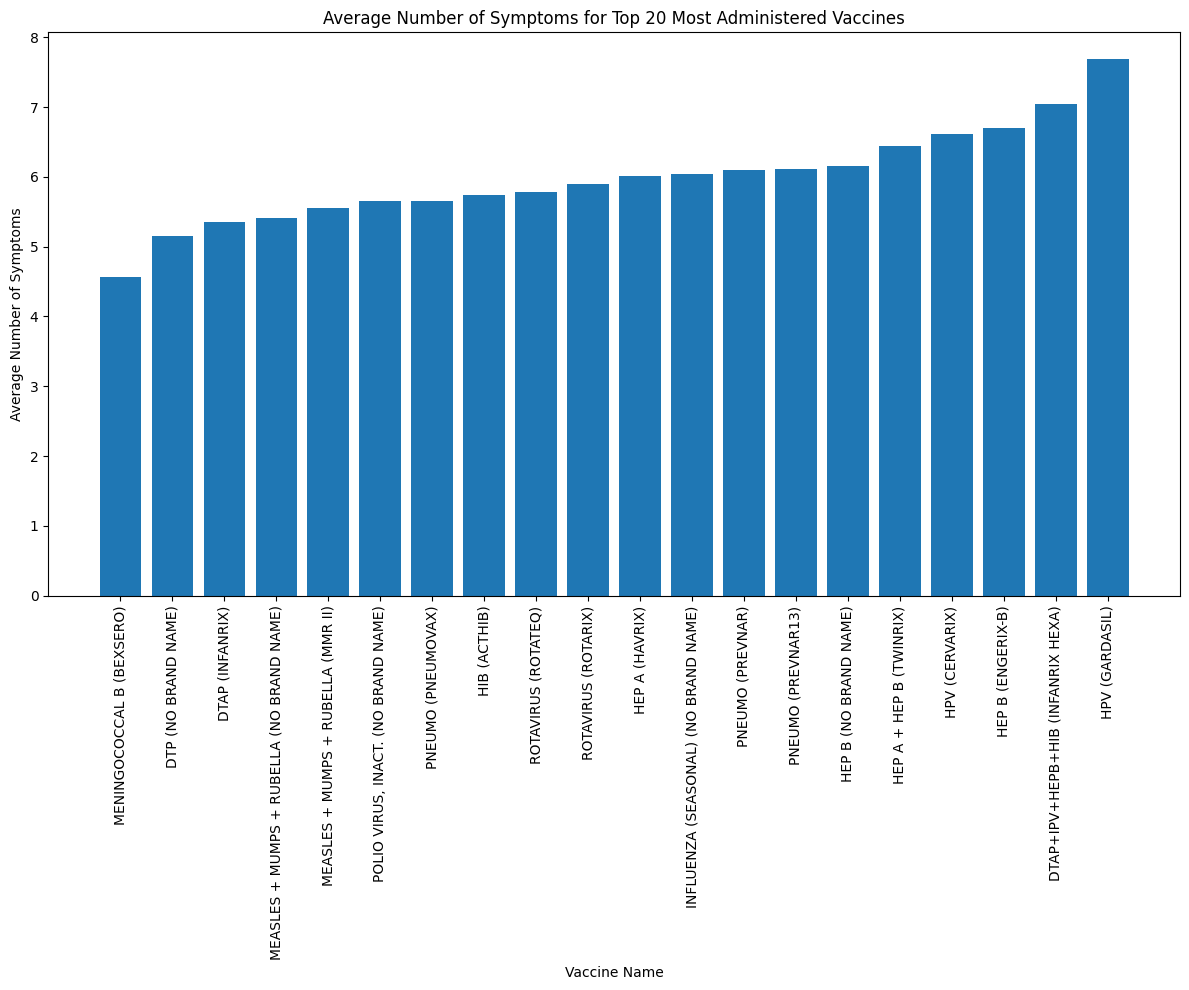

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 10))
plt.bar(top20_df['VAX_NAME'], top20_df['AVERAGE_SYMPTOMS'])
plt.xlabel('Vaccine Name')
plt.ylabel('Average Number of Symptoms')
plt.title('Average Number of Symptoms for Top 20 Most Administered Vaccines')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 3.2 MBA pour les observations de 2024 (15 points)

En utilisant les commandes du ``OBSERVATIONS_extract.csv``, créez un bloc de données où chaque ligne contient la liste des symptomes observés pour chaque patient, de manière similaire au GroceryDataset. Ensuite, exécutez l'algorithme MBA pour cet ensemble de transactions.
Le format devra permettre d'appeler l'ensemble des méthodes précédemment implémentées.

- Vous devez signaler le temps passé pour effectuer cette tâche.
- La sortie doit contenir le nom des symptômes.

In [ ]:
%%time
"""
TODO: create a query to create and struct the transactions
"""
df_symptoms_sub = spark.sql("""
  SELECT observ.VAERS_ID as order_id, concat_ws(',', sort_array(collect_list(struct(symp.SYMPTOM_NAME))).SYMPTOM_NAME) as transaction
  FROM SYMPTOMS AS symp INNER JOIN OBSERVATIONS as observ
  ON symp.SYMPTOM_ID == observ.SYMPTOM_ID INNER JOIN Vax as vax ON vax.VAERS_ID == observ.VAERS_ID
  GROUP BY observ.VAERS_ID
""")

df_symptoms_sub.show(20, truncate=False)

+--------+----------------------------------------------------------------------------------------------------------------------------------------+
|order_id|transaction                                                                                                                             |
+--------+----------------------------------------------------------------------------------------------------------------------------------------+
|25010   |Bronchitis                                                                                                                              |
|25055   |Hepatic function abnormal,Hepatocellular damage,Nausea,Neoplasm malignant                                                               |
|25057   |Anaphylactoid reaction                                                                                                                  |
|25058   |Convulsion,Electroencephalogram abnormal,Headache                                                     

Attention, l'exécution de cellule-ci devrait prendre plusieurs dizaines de minutes, dépendamment de l'implémentation que vous avez codé.

In [ ]:
%%time
"""
TODO: run the MBA algorithm and show the first 5 association rules
"""
df_symptoms_sub_rdd = df_symptoms_sub.rdd
patterns_symptoms_rdd = df_symptoms_sub_rdd.flatMap(map_to_patterns)
combined_patterns_symptoms_rdd = patterns_symptoms_rdd.reduceByKey(reduce_patterns)
subpatterns_symptoms_rdd = combined_patterns_symptoms_rdd.flatMap(map_to_subpatterns)
combined_rules_symptoms = subpatterns_symptoms_rdd.groupByKey().mapValues(list)
assoc_rules_symptoms = combined_rules_symptoms.flatMapValues(map_to_assoc_rules)

CPU times: user 43.2 ms, sys: 5.17 ms, total: 48.3 ms
Wall time: 4.65 s


In [ ]:
%%time
assoc_rules_symptoms_mapped = assoc_rules_symptoms.map(format_tuples).toDF(['patterns', 'association_rules'])

CPU times: user 15 s, sys: 1.79 s, total: 16.8 s
Wall time: 43min 22s


In [ ]:
%%time
assoc_rules_symptoms_mapped.sort(['patterns']).show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 4. MBA pour le dataset complet (20 points)


Comme vous l'avez probablement remarqué, même pour un ensemble de données moins volumineux, l'algorithme MBA est coûteux en calcul. Pour cette raison, cette fois, nous allons répéter le processus, mais en utilisant maintenant Google Cloud Platform (GCP) pour créer un grand cluster. Toutes les instructions pour créer un cluster avec spark et comment soumettre un travail seront expliquées dans le laboratoire. Dans tous les cas, vous devez lire les instructions données dans le ``Instruction_GCP.pdf``.

Cette fois, nous travaillerons avec le fichier ``OBSERVATIONS.csv``, qui contient plusieurs millions d'observations.

**PRODUCTION ATTENDUE**

Après avoir exécuté le MBA pour la plus grande collection d'observation, sélectionnez au hasard UN symptôme observé dans ``OBSERVATIONS`` et affichez les règles d'association (nom du symptôme et valeur d'association) de ce symptôme, c'est-à-dire lorsque le symptôme est seul. La sortie doit être formatée dans un tableau, où chaque ligne contenant les informations d'un symptôme associé.
Afin d'accélérer son exécution, vous pouvez créer un second notebook uniquement dédié à cette partie et l'insérer dans le rendu final.

- Affichez l'identifiant (SYMPTOM_ID) et le nom du symptôme (SYMPTOM_NAME) sélectionné au hasard.
- Signalez le temps d'exécution.

**Remarque importante : joignez des captures d'écran de votre sortie et de votre configuration de cluster.**

Voici la configuration utilisée pour le cluster.

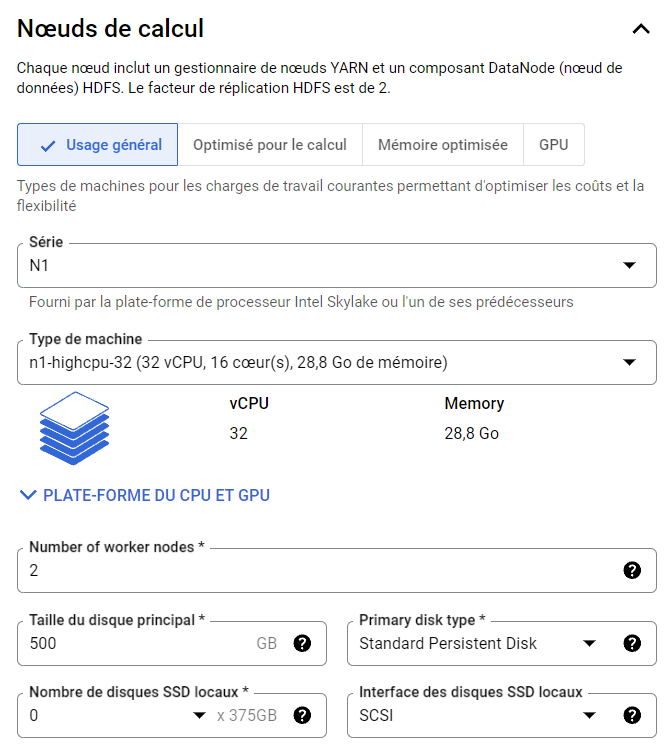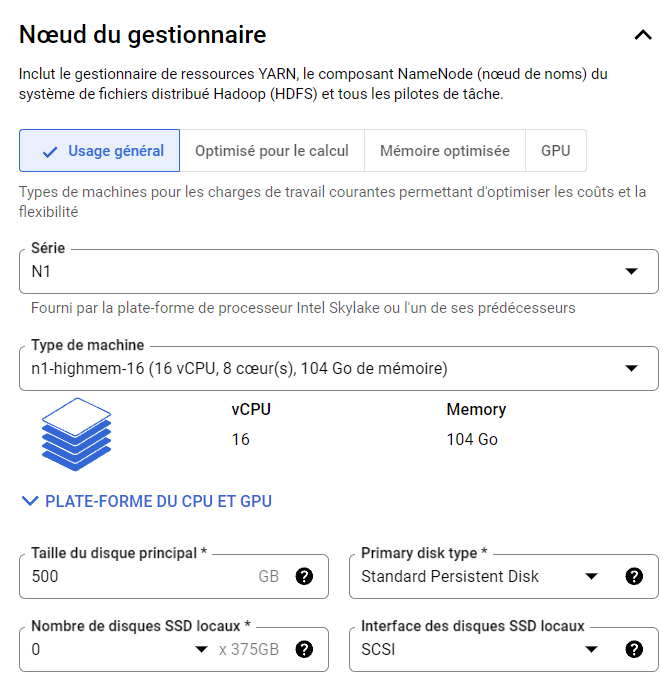

Nous avons exéuté le MBA deux fois. Les premiers résultats sont visibles en imags et les deuxièmes en sortie comme résultat.

In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
ROOT = "gs://buckettp3inf8111/"

In [ ]:
spark.conf.set("spark.sql.shuffle.partitions", "100")
spark.conf.set("spark.storage.memoryFraction", "0.3")
spark.conf.set("spark.local.dir", "/tmp/spark-temp")  # Temp directory for spills

In [ ]:
df_observations_gcp = spark.read.csv(ROOT+'OBSERVATIONS.csv', header=True, sep=',', inferSchema=True)
df_symptoms = spark.read.csv(ROOT + 'SYMPTOMS.csv', header=True, sep=',', inferSchema=True)
df_vax = spark.read.csv(ROOT + 'VAX.csv', header=True, sep=',', inferSchema=True)

In [ ]:
df_observations_gcp.createOrReplaceTempView("OBSERVATIONS") # creates table 'observations'
df_symptoms.createOrReplaceTempView("SYMPTOMS") # creates table 'symptoms'
df_vax.createOrReplaceTempView("VAX") # creates table 'vax'

In [ ]:
%%time
"""
TODO: create a query to create and struct the transactions from the OBSERVATIONS.csv file
"""
df_symptoms_sub_gcp = spark.sql("""
  SELECT observ.VAERS_ID as order_id, concat_ws(',', sort_array(collect_list(struct(symp.SYMPTOM_NAME))).SYMPTOM_NAME) as transaction
  FROM SYMPTOMS AS symp INNER JOIN OBSERVATIONS as observ
  ON symp.SYMPTOM_ID == observ.SYMPTOM_ID INNER JOIN Vax as vax ON vax.VAERS_ID == observ.VAERS_ID
  GROUP BY observ.VAERS_ID
""")

CPU times: user 2.8 ms, sys: 0 ns, total: 2.8 ms
Wall time: 199 ms


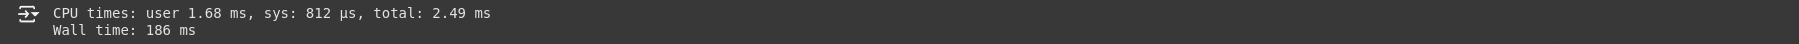

In [ ]:
%%time
df_symptoms_sub_gcp.show(20, truncate=False)

+--------+-------------------------------------------------------------------------------------------------------------------+
|order_id|transaction                                                                                                        |
+--------+-------------------------------------------------------------------------------------------------------------------+
|25055   |Hepatic function abnormal,Hepatocellular damage,Nausea,Neoplasm malignant                                          |
|25520   |Sepsis                                                                                                             |
|25555   |Convulsion,Pyrexia                                                                                                 |
|25711   |Abdominal pain,Anaphylactoid reaction,Angina pectoris,Chest pain,Dizziness,Nausea,Pallor,Paraesthesia,Shock,Syncope|
|25818   |Confusional state,Encephalitis,Hyperventilation,Leukocytosis,Overdose                                

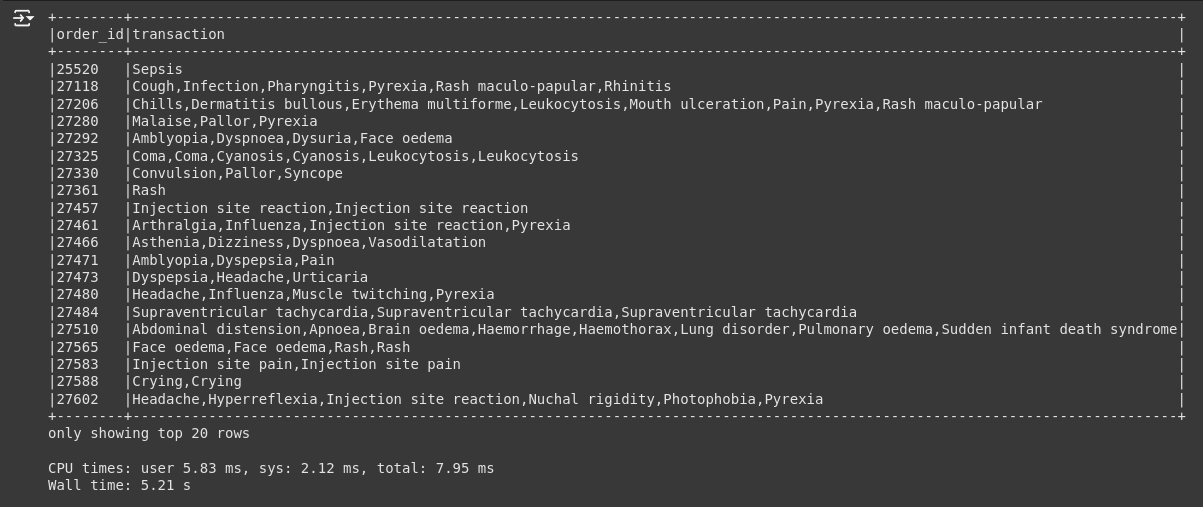

In [ ]:
from itertools import combinations

def format_tuples(pattern):
    return (str(pattern[0]), str(pattern[1]))

def map_to_patterns(row):
    products = sorted(row.transaction.split(","))
    n = len(products)

    for size in range(1, 4):
        for comb in combinations(products, size):
            yield (tuple(comb), 1)

def reduce_patterns(v1, v2):
    return v1 + v2

def map_to_subpatterns(pattern):
    subpattern, values = pattern
    n = len(subpattern)

    if n == 1:
        yield (subpattern, (None, values))
    else:
        yield (subpattern, (None, values))
        for i in range(n):
            subpattern_i = subpattern[:i] + subpattern[i+1:]
            yield (tuple(subpattern_i), (subpattern[i], values))

def map_to_assoc_rules(rule):
    if len(rule) > 1:
        total = rule[0][1]
        yield [(element[0], element[1] / total) for element in rule[1:]]
    else:
        yield []

In [ ]:
%%time
"""
TODO: run the MBA algorithm and print the requested output
"""
df_symptoms_sub_rdd_gcp = df_symptoms_sub_gcp.rdd
patterns_symptoms_rdd_gcp = df_symptoms_sub_rdd_gcp.flatMap(map_to_patterns)
combined_patterns_symptoms_rdd_gcp = patterns_symptoms_rdd_gcp.reduceByKey(reduce_patterns)
subpatterns_symptoms_rdd_gcp = combined_patterns_symptoms_rdd_gcp.flatMap(map_to_subpatterns)
combined_rules_symptoms_gcp = subpatterns_symptoms_rdd_gcp.groupByKey().mapValues(list)
assoc_rules_symptoms_gcp = combined_rules_symptoms_gcp.flatMapValues(map_to_assoc_rules)


CPU times: user 23.8 ms, sys: 1.49 ms, total: 25.3 ms
Wall time: 6.42 s


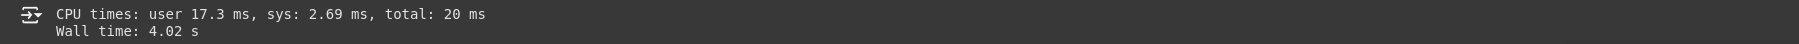

In [ ]:
%%time
assoc_rules_symptoms_mapped_gcp = assoc_rules_symptoms_gcp.map(format_tuples).toDF(['patterns', 'association_rules'])

CPU times: user 511 ms, sys: 180 ms, total: 690 ms
Wall time: 57min


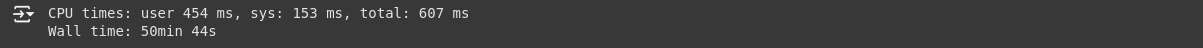

In [ ]:
%%time
assoc_rules_symptoms_mapped_gcp.sort(['patterns']).show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

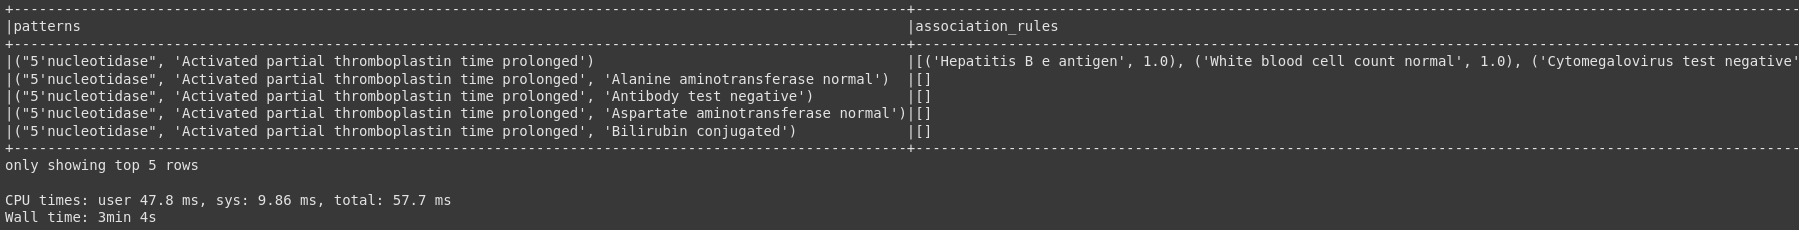

In [ ]:
from pyspark.sql.functions import rand, col, lit, concat_ws
random_symptome = df_observations_gcp.orderBy(rand()).limit(1)
rand_row = df_symptoms.join(random_symptome, on="SYMPTOM_ID").select(
    "SYMPTOM_ID", "SYMPTOM_NAME"
)

rand_row_rdd = rand_row.select(rand_row.SYMPTOM_ID.alias('order_id'),rand_row.SYMPTOM_NAME.alias('transaction')).rdd
rand_row_rdd = rand_row_rdd.flatMap(map_to_patterns)
rand_row_rdd = rand_row_rdd.reduceByKey(reduce_patterns)
rand_row_rdd = rand_row_rdd.flatMap(map_to_subpatterns)
rand_row_rdd = rand_row_rdd.groupByKey().mapValues(list)
rand_row_rdd = rand_row_rdd.flatMapValues(map_to_assoc_rules)

In [ ]:
rand_row.show(1)

+----------+----------------+
|SYMPTOM_ID|    SYMPTOM_NAME|
+----------+----------------+
|     11708|Drug ineffective|
+----------+----------------+



In [ ]:
rand_row_df = rand_row_rdd.map(format_tuples).toDF(['patterns', 'association_rules'])
rand_row.patterns = rand_row_df.patterns

Deux symptômes ont été sélectionnés au hasard : Drug ineffective et Syncope

In [ ]:
rand_row.show(1)

+----------+----------------+
|SYMPTOM_ID|    SYMPTOM_NAME|
+----------+----------------+
|     11708|Drug ineffective|
+----------+----------------+



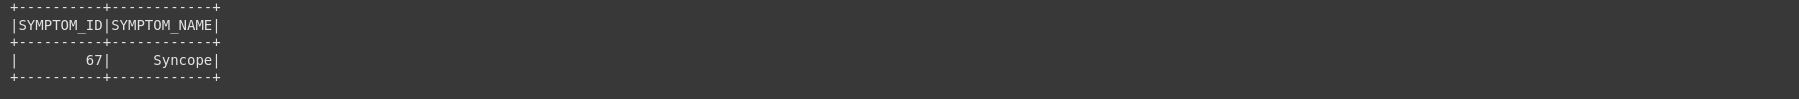

In [ ]:
from pyspark.sql import *
from pyspark.sql.functions import *

w=Window.orderBy(lit(1))

rand_row_df=rand_row_df.withColumn("rn",row_number().over(w)-1)
rand_row=rand_row.withColumn("rn",row_number().over(w)-1)

rand_row_all = rand_row.join(rand_row_df,["rn"]).drop("rn")

In [ ]:
rand_row_all.show()

24/12/13 23:00:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 23:00:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 23:00:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 23:00:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 23:00:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 23:00:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 2

+----------+----------------+--------------------+-----------------+
|SYMPTOM_ID|    SYMPTOM_NAME|            patterns|association_rules|
+----------+----------------+--------------------+-----------------+
|     11708|Drug ineffective|('Drug ineffectiv...|               []|
+----------+----------------+--------------------+-----------------+



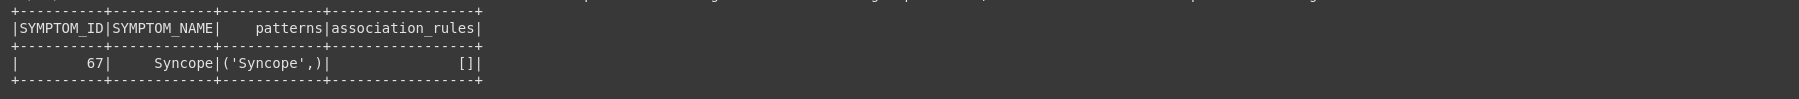

In [ ]:
%%time
res=rand_row_all.join(assoc_rules_symptoms_mapped_gcp, on="patterns").select(rand_row.SYMPTOM_ID,rand_row.SYMPTOM_NAME,assoc_rules_symptoms_mapped_gcp.association_rules)

CPU times: user 3.27 ms, sys: 1.43 ms, total: 4.7 ms
Wall time: 20.1 ms


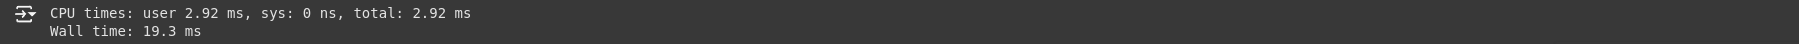

In [ ]:
%%time
res.show(truncate=False)

24/12/13 23:09:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 23:09:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 23:09:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 23:09:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 23:09:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 23:09:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 2

+----------+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

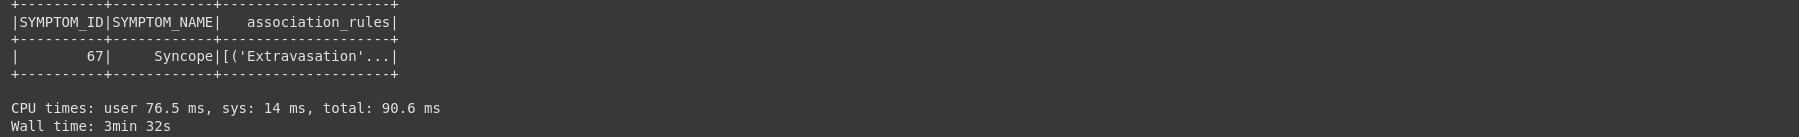